# LangGraph 활용 Agent 구축

학습 목표 
- LangGraph에 웹 검색 도구 + LLM Agent 추가 
- LLM 에 도구를 바인딩 -> LLM 에 입력된 요청에 따라 필요시 웹 검색 도구(Tool)를 호출하는 Agent 을 구축
- 조건부 엣지를 통해 도구 호출 여부에 따라 다른 노드로 라우팅하는 방법 배우기 



## Agent를 LangGraph와 함께 사용하는 것에 대한 장점

Agent만 단독으로 사용하는 경우 컨트롤이 어렵다. 
- 예를들어, 문서 검색 도구와 웹 검색 도구 2가지 도구가 바인딩 된 Agent를 사용한다고 가정하자.  
- 문서 검색 도구를 사용해서 내가 보유한 문서를 우선적으로 검색하여 답변을 생성하기를 원하지만, 웹 검색을 해서 적절한 답변 생성을 수행하지 못하는 경우가 있다. 
- 단대로 웹 검색을 해야하는데 문서 검색을 해서 필요 없는 정보들을 제공할 수 있다. 

Agent를 LangGraph와 결합할 경우 컨트롤에 용이하다.
- Agent가 사용한 도구를 선정할 때, LangGraph의 노드들이 이를 확인해줄 수 있다. 
- 또는 LangGraph에 Human-in-the-loop 이 있기 때문에 사람의 개입을 통해 Agent가 적절한 도구를 사용하게 할 수 있다. 

## 도구(Tool) 사용하기

- pre-trained llm이 답변할 수 없는 질문을 처리하기 위해 `웹 검색 도구`를 통합
- 도구를 사용하여 더 나은 응답을 제공

**참고**

- [도구(Tools)](https://wikidocs.net/262582)


### 검색 API 도구

웹 검색 도구 : Tavily 검색 API를 활용
- `TavilySearchResults`와 `TavilyAnswer`.


**API 키 발급 주소**
- https://app.tavily.com/

발급한 API 키를 환경변수에 설정

- `.env` 파일에 아래와 같이 설정

```
TAVILY_API_KEY=tvly-abcdefghijklmnopqrstuvwxyz
```

### TavilySearchResults

**설명**
- Tavily 검색 API를 쿼리하고 JSON 형식의 결과를 반환
- 포괄적이고 정확하며 신뢰할 수 있는 결과에 최적화된 검색 엔진

다음으로 웹 검색 도구인 `TavilySearchResults`를 생성합니다.

In [1]:
# !pip install -U langchain-teddynote

In [2]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

True

In [3]:
from langchain_teddynote.tools.tavily import TavilySearch

# 검색 도구 생성
tool = TavilySearch(max_results=3)

# 도구 목록에 추가
tools = [tool]

# 도구 실행
print(tool.invoke("테디노트 랭체인 튜토리얼"))
# 생성된 내용은 챗봇이 질문에 답할 수 있도록 사용할 수 있는 페이지 요약입니다.

[{'title': '랭체인(langchain)의 OpenAI GPT 모델(ChatOpenAI) 사용법 (1) - 테디노트', 'url': 'https://teddylee777.github.io/langchain/langchain-tutorial-01/', 'content': "랭체인(langchain)의 OpenAI GPT 모델(ChatOpenAI) 사용법 (1) - 테디노트 랭체인(langchain)의 OpenAI GPT 모델(ChatOpenAI) 사용법 (1) 랭체인(langchain)의 OpenAI GPT 모델(ChatOpenAI) 사용법 (1) 튜토리얼은 시리즈 형식으로 구성되어, 시리즈를 거듭하면서 랭체인(LangChain) 을 통해 언어 모델 기반의 애플리케이션 개발은 더욱 간결하고 효과적으로 이루어질 수 있습니다. ada-code-search-text code-search-ada-text-001 result = llm_chain.apply(input_list) generated_result = llm_chain.generate(input_list) generations=[[ChatGeneration(text='호주의 수도는 캔버라입니다.', generation_info={'finish_reason': 'stop'}, message=AIMessage(content='호주의 수도는 캔버라입니다.', additional_kwargs={}, example=False))], [ChatGeneration(text='중국의 수도는 베이징(北京)입니다.', generation_info={'finish_reason': 'stop'}, message=AIMessage(content='중국의 수도는 베이징(北京)입니다.', additional_kwargs={}, example=False))], [ChatGeneration(text='네덜란드의 수도는 암스테르담(Amsterdam)입니다.', generation_info={'finish_reason': 'stop'},


이번에는 LLM에 `bind_tools`를 추가하여 **LLM + 도구** 를 구성 

1. State 정의

In [4]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages


# 1. State 정의
class State(TypedDict):
    # list 타입에 add_messages 적용(list 에 message 추가)
    messages: Annotated[list, add_messages]

LLM 을 정의하고 도구를 바인딩합니다.

In [5]:
from langchain_openai import ChatOpenAI

# LLM 초기화
llm = ChatOpenAI(model="gpt-4o-mini")

# LLM 에 도구 바인딩
llm_with_tools = llm.bind_tools(tools)

2. 노드를 정의

In [6]:
# 노드 함수 정의
def chatbot(state: State):
    answer = llm_with_tools.invoke(state["messages"])
    # 메시지 목록 반환
    return {"messages": [answer]}  # 자동으로 add_messages 적용

3. 그래프 생성

In [7]:
from langgraph.graph import StateGraph

# 상태 그래프 초기화
graph_builder = StateGraph(State)


4. 노드를 추가합니다.

In [8]:
# 노드 추가
graph_builder.add_node("chatbot", chatbot)

## 도구 노드(Tool Node)

지금은 직접 구현하지만, 나중에는 LangGraph의 pre-built 되어있는 [ToolNode](https://langchain-ai.github.io/langgraph/reference/prebuilt/#langgraph.prebuilt.tool_node.ToolNode)를 사용

- 도구가 호출될 경우 실제로 실행할 수 있는 함수를 만들어야 한다.
- 이를 위해 새로운 노드에 도구를 추가
- 가장 최근의 메시지를 확인하고 메시지에 `tool_calls`가 포함되어 있으면 도구를 호출하는 `BasicToolNode`를 구현



In [9]:
import json
from langchain_core.messages import ToolMessage


class BasicToolNode:
    """Run tools requested in the last AIMessage node"""

    def __init__(self, tools: list) -> None:
        self.tools_list = {tool.name: tool for tool in tools}       # 도구 리스트

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):                  # 메시지가 존재할 경우 가장 최근 메시지 1개 추출
            message = messages[-1]
        else:
            raise ValueError("No message found in input")

        # 도구 호출 결과
        outputs = []
        for tool_call in message.tool_calls:
            # 도구 호출 후 결과 저장
            tool_result = self.tools_list[tool_call["name"]].invoke(tool_call["args"])
            outputs.append(
                # 도구 호출 결과를 메시지로 저장
                ToolMessage(
                    content=json.dumps(
                        tool_result, ensure_ascii=False
                    ),  # 도구 호출 결과를 문자열로 변환
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )

        return {"messages": outputs}            # 어떤 도구를 사용했는지 그리고 그 결과가 무엇인지 반환 -> llm에게 다시 제공 


# 도구 노드 생성
tool_node = BasicToolNode(tools=[tool])

# 그래프에 도구 노드 추가
graph_builder.add_node("tools", tool_node)

## 조건부 엣지(Conditional Edge)

`conditional_edges` 정의

**Edges**는 한 노드에서 다음 노드로 제어 흐름을 라우팅

**Conditional edges**는 일반적으로 "if" 문을 포함하여 현재 그래프 상태에 따라 다른 노드로 라우팅 한다.

이러한 함수는 현재 그래프 `state`를 받아 다음에 호출할 Node 를 나타내는 **문자열 또는 문자열 목록** 을 반환한다.

아래에서는 `route_tools`라는 라우터 함수를 정의하여 챗봇의 출력에서 `tool_calls`를 확인하고 있다.

이 함수를 `add_conditional_edges`를 호출하여 그래프에 제공하면, `chatbot` 노드가 완료될 때마다 이 함수를 확인하여 다음으로 어디로 갈지 결정한다.

조건은 도구 호출이 있으면 `tools`로, 없으면 `END`로 라우팅된다.

**참고**

- langgraph 에 pre-built 되어 있는 [tools_condition](https://langchain-ai.github.io/langgraph/reference/prebuilt/#tools_condition) 으로 대체할 수 있습니다.

### `add_conditional_edges`

![add_conditional_edges](https://github.com/user-attachments/assets/ee25ce94-95a9-4670-86ec-2474057b0555)

`add_conditional_edges` 메서드는 시작 노드에서 여러 대상 노드로의 조건부 엣지를 추가합니다.

**매개변수**
- `source` (str): 시작 노드. 이 노드를 나갈 때 조건부 엣지가 실행됩니다.
- `path` (Union[Callable, Runnable]): 다음 노드를 결정하는 호출 가능한 객체 또는 Runnable. `path_map`을 지정하지 않으면 하나 이상의 노드를 반환해야 합니다. `END`를 반환하면 그래프 실행이 중지됩니다.
- `path_map` (Optional[Union[dict[Hashable, str], list[str]]]): 경로와 노드 이름 간의 매핑. 생략하면 `path`가 반환하는 값이 노드 이름이어야 합니다.
- `then` (Optional[str]): `path`로 선택된 노드 실행 후 실행할 노드의 이름.

**반환값**
- Self: 메서드 체이닝을 위해 자기 자신을 반환합니다.
### `add_conditional_edges`

![add_conditional_edges](./image/langgraph-02.png)

`add_conditional_edges` 메서드는 시작 노드에서 여러 대상 노드로의 조건부 엣지를 추가한다.

**매개변수**
- `source` (str): 
    + 시작 노드. 이 노드를 나갈 때 조건부 엣지가 실행됩니다.
- `path` (Union[Callable, Runnable]): 
    + 다음 노드를 결정하는 호출 가능한 객체 또는 Runnable. 
    + `path_map`을 지정하지 않으면 하나 이상의 노드를 반환해야 한다.
    + `END`를 반환하면 그래프 실행이 중지된다. 
- `path_map` (Optional[Union[dict[Hashable, str], list[str]]]): 
    + 경로와 노드 이름 간의 매핑. 
    + 생략하면 `path`가 반환하는 값이 노드 이름이어야 한다.
- `then` (Optional[str]): 
    +`path`로 선택된 노드 실행 후 실행할 노드의 이름.

**예시**

```python
# `tools_condition` 함수는 챗봇이 도구 사용을 요청하면 "tools"를 반환하고, 직접 응답이 가능한 경우 "END"를 반환
graph_builder.add_conditional_edges(
    source="chatbot",
    path=route_tools,
    path_map={"tools": "tools", END: END},  # route_tools 의 반환값이 "tools" 인 경우 "tools" 노드로, 그렇지 않으면 END 노드로 라우팅
)
```

**반환값**
- Self: 메서드 체이닝을 위해 자기 자신을 반환한다.

**주요 기능**
1. 조건부 엣지를 그래프에 추가
2. `path_map`을 딕셔너리로 변환
3. `path` 함수의 반환 타입을 분석하여 자동으로 `path_map` 생성 가능
4. 조건부 분기를 그래프에 저장

**참고**
- 이미 컴파일된 그래프에 엣지를 추가하면 경고 메시지가 출력
- `path` 함수의 반환 값에 대한 타입 힌트가 없거나 `path_map`이 제공되지 않으면, 그래프 시각화 시 해당 엣지가 그래프의 모든 노드로 전환될 수 있다고 가정한다.
- 동일한 이름의 분기가 이미 존재하는 경우 `ValueError`가 발생한다.



In [10]:
from langgraph.graph import START, END


def route_tools(
    state: State,
):
    if messages := state.get("messages", []):
        # 가장 최근 AI 메시지 추출
        ai_message = messages[-1]
    else:
        # 입력 상태에 메시지가 없는 경우 예외 발생
        raise ValueError(f"No messages found in input state to tool_edge: {state}")

    # AI 메시지에 도구 호출이 있는 경우 "tools" 반환
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        # 도구 호출이 있는 경우 "tools" 반환
        return "tools"
    # 도구 호출이 없는 경우 "END" 반환
    return END


# `tools_condition` 함수는 챗봇이 도구 사용을 요청하면 "tools"를 반환하고, 직접 응답이 가능한 경우 "END"를 반환
graph_builder.add_conditional_edges(
    source="chatbot",
    path=route_tools,
    # route_tools 의 반환값이 "tools" 인 경우 "tools" 노드로, 그렇지 않으면 END 노드로 라우팅
    path_map={"tools": "tools", END: END},
)

# tools > chatbot
graph_builder.add_edge("tools", "chatbot")

# START > chatbot
graph_builder.add_edge(START, "chatbot")

# 그래프 컴파일
graph = graph_builder.compile()

**조건부 엣지**가 단일 노드에서 시작해야 합니다.

이는 그래프에 "`chatbot`" 노드가 실행될 때마다 도구를 호출하면 'tools'로 이동하고, 직접 응답하면 루프를 종료하라는 의미입니다. 

사전 구축된 `tools_condition`처럼, 함수는 도구 호출이 없을 경우 `END` 문자열을 반환(그래프 종료) 합니다. 그래프가 `END`로 전환되면 더 이상 완료할 작업이 없으며 실행을 중지합니다.

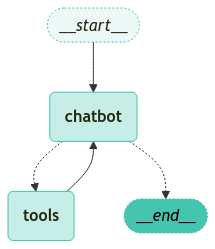

In [11]:
from langchain_teddynote.graphs import visualize_graph

# 그래프 시각화
visualize_graph(graph)

이제 봇에게 훈련 데이터 외의 질문을 할 수 있습니다.

In [13]:
inputs = {"messages": "Physical AI에 대해서 알려줘."}

for event in graph.stream(inputs, stream_mode="values"):
    for key, value in event.items():
        print(f"\n==============\nSTEP: {key}\n==============\n")
        # display_message_tree(value["messages"][-1])
        print(value[-1])


STEP: messages

content='Physical AI에 대해서 알려줘.' additional_kwargs={} response_metadata={} id='412085ad-9da2-4bbd-b9ef-d2ea2cd6f465'

STEP: messages

content='' additional_kwargs={'tool_calls': [{'id': 'call_cc4VbPro8njzG0liwYtcDvNu', 'function': {'arguments': '{"query":"Physical AI 정의 및 이점"}', 'name': 'tavily_web_search'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 98, 'total_tokens': 121, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_709714d124', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-0d7fefab-b7f9-4d8d-a0a9-58c9a30a5882-0' tool_calls=[{'name': 'tavily_web_search', 'args': {'query': 'Physical AI 정의 및 이점'}, 'id': 'call_cc4VbPro8njzG0liwYtcDvNu', 'type': 'tool_call'}] usage_

도구 호출 후 구조에 대한 이미지

![Image](https://github.com/user-attachments/assets/636bfe30-e5e5-4a0c-a6b8-da2c720db522)

![](./image/tool-message-01.png)